# Project Benson
WomenTechWomenYes (WTWY) has an annual gala at the beginning of the summer each year. As they are a new and inclusive organization, they try to do double duty with the gala both to fill event space with individuals passionate about increasing the participation of women in technology, and to concurrently build awareness and reach. They place street teams at entrances to subway stations. The street teams collect email addresses and those who sign up are sent free tickets to the gala. They want to use MTA subway data to help optimize the placement of street teams, such that they can gather the most signatures, ideally from those who will attend the gala and contribute to our cause. Other data can be used as well.

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
pd.options.display.float_format = '{:.2f}'.format


%matplotlib inline

Read and combine data tables for May 2017.

In [104]:
weeks = [170506, 170513, 170520, 170527]
url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'
df_list = []
for week in weeks:
    df_list.append(pd.read_csv(url.format(week)))
mta_df = pd.concat(df_list)

In [105]:
mta_df.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/29/2017,00:00:00,REGULAR,6157740,2085315
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/29/2017,04:00:00,REGULAR,6157777,2085319
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/29/2017,08:00:00,REGULAR,6157810,2085353
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/29/2017,12:00:00,REGULAR,6157963,2085453
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/29/2017,16:00:00,REGULAR,6158212,2085529
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/29/2017,20:00:00,REGULAR,6158521,2085589
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/30/2017,00:00:00,REGULAR,6158637,2085612
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/30/2017,04:00:00,REGULAR,6158654,2085617
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/30/2017,08:00:00,REGULAR,6158661,2085641
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/30/2017,12:00:00,REGULAR,6158703,2085730


For each turnstile, store the total entries over 24 hours. A problem that we saw in some examples was the entries count for some turnstiles decreased. The counters were counting backward. We used the absolute value of the difference to solve this.

In [106]:
temp_d = defaultdict(list)
turnstile_d = {}
for row in mta_df.itertuples():
    C_A, unit, scp, station, linename, date = row[1], row[2], row[3], row[4], ''.join(sorted(row[5])), row[7]
    entries = row[10]
    k = (C_A, unit, scp, station, linename, date)
    #temp_d[k].append(entries)
    if k not in temp_d:
        temp_d[k] = [entries]
    else:
        temp_d[k].append(entries)
for key, value in temp_d.items():
    entry = abs(max(value) - min(value))
    turnstile_d[key] = [entry]

Convert dictionary into a dataframe with numeric indexes.

In [107]:
dict_df = pd.DataFrame.from_dict(turnstile_d, orient='index')
dict_df.rename(columns = {0:'Entries'}, inplace=True)
dict_df.head(10)

,Entries
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 04/29/2017)",781
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 04/30/2017)",378
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/01/2017)",1267
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/02/2017)",1322
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/03/2017)",1193
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/04/2017)",1348
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/05/2017)",1072
"(A002, R051, 02-00-01, 59 ST, 456NQRW, 04/29/2017)",646
"(A002, R051, 02-00-01, 59 ST, 456NQRW, 04/30/2017)",538
"(A002, R051, 02-00-01, 59 ST, 456NQRW, 05/01/2017)",976


In [108]:
turnstile_df = pd.DataFrame(columns=[])
turnstile_df['C/A'] = [row[0][0] for row in dict_df.itertuples()]
turnstile_df['Unit'] = [row[0][1] for row in dict_df.itertuples()]
turnstile_df['SCP'] = [row[0][2] for row in dict_df.itertuples()]
turnstile_df['Station'] = [row[0][3] for row in dict_df.itertuples()]
turnstile_df['Linename'] = [row[0][4] for row in dict_df.itertuples()]
turnstile_df['Date'] = [row[0][5] for row in dict_df.itertuples()]
turnstile_df['Entries'] = [row[1] for row in dict_df.itertuples()]

Another problem was that some turnstiles would reset by setting their entries counter to a unrealistically large number. When calculating the entries per day, if there was a suspiciously large number, that row was deleted.

In [109]:
def delete_outliers(df, iters=5):
    """
    Finds the max values in a dataframe grouped by columns and removes them
    :param df: dataframe
    :param iters: number of outliers to delete
    :return: 
    """
    for i in range(iters):
        to_delete_rows = df.loc[df.groupby(["Station","Linename"])['Entries'].idxmax()]
        to_delete_indices = list(to_delete_rows.index.values)
        df.drop(to_delete_indices, inplace=True)
    return df

In [110]:
no_outliers_turnstile_df = delete_outliers(turnstile_df)
no_outliers_turnstile_df['Entries'].max()

8170

Get all stations, linenames, and total entries for May.

In [145]:
pd.to_datetime(no_outliers_turnstile_df['Date'])
no_outliers_turnstile_df.groupby(['Linename', 'Station']).sum().sort_values(by='Entries',ascending=False).head(10)

busiest_turnstile_df = no_outliers_turnstile_df.groupby(['Linename','Station']).sum()
busiest_turnstile_df = busiest_turnstile_df.sort_values(by='Entries',ascending=False)
busiest_turnstile_df.reset_index(inplace=True)
busiest_turnstile_df.head(10)

,Linename,Station,Entries
0,4567S,GRD CNTRL-42 ST,3197912
1,BDFMNQRW,34 ST-HERALD SQ,2648443
2,456LNQRW,14 ST-UNION SQ,2302412
3,2345ACJZ,FULTON ST,1966880
4,1237ACENQRSW,42 ST-PORT AUTH,1963100
5,ACE,34 ST-PENN STA,1721122
6,1237ACENQRSW,TIMES SQ-42 ST,1619528
7,1ABCD,59 ST COLUMBUS,1544288
8,7,FLUSHING-MAIN,1353159
9,123ACE,34 ST-PENN STA,1230277


In [146]:
times_sq_entries = int(busiest_turnstile_df.iloc[[4]]['Entries'].values)
st_penn_entries = int(busiest_turnstile_df.iloc[[5]]['Entries'].values)

times_sq_dup_entries = int(busiest_turnstile_df.iloc[[6]]['Entries'].values)
st_penn_dup_entries = int(busiest_turnstile_df.iloc[[9]]['Entries'].values)

In [147]:
busiest_turnstile_no_dup_df = busiest_turnstile_df
busiest_turnstile_no_dup_df.drop([6,9],inplace=True)

In [155]:
busiest_turnstile_no_dup_df.loc[4, 'Entries'] = times_sq_entries + times_sq_dup_entries
busiest_turnstile_no_dup_df.loc[5, 'Entries'] = st_penn_entries + st_penn_dup_entries
busiest_turnstile_no_dup_df = busiest_turnstile_df.sort_values(by='Entries',ascending=False)[:20]
busiest_turnstile_no_dup_df

,Linename,Station,Entries
4,1237ACENQRSW,42 ST-PORT AUTH,3582628
0,4567S,GRD CNTRL-42 ST,3197912
5,ACE,34 ST-PENN STA,2951399
1,BDFMNQRW,34 ST-HERALD SQ,2648443
2,456LNQRW,14 ST-UNION SQ,2302412
3,2345ACJZ,FULTON ST,1966880
7,1ABCD,59 ST COLUMBUS,1544288
8,7,FLUSHING-MAIN,1353159
10,456NQRW,59 ST,1213855
11,1,PATH NEW WTC,1194599


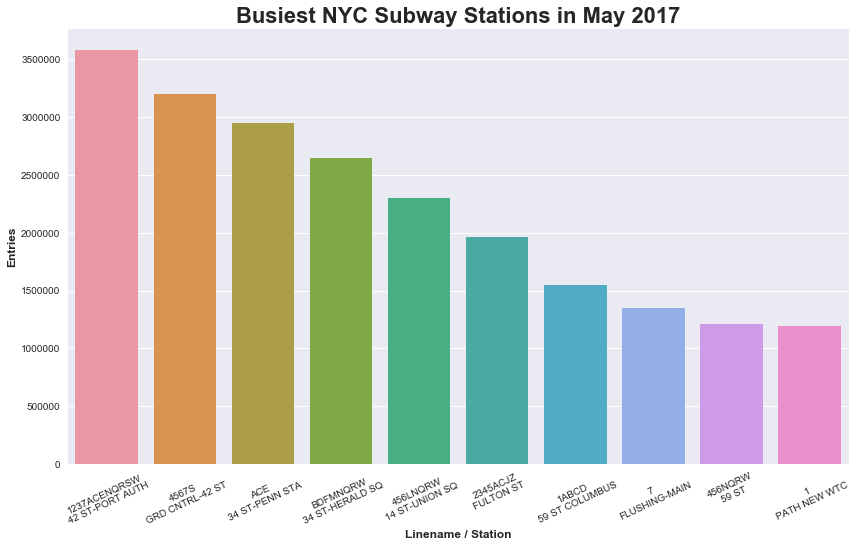

In [152]:
plt.figure(figsize=(14,8))
sb.barplot(busiest_turnstile_no_dup_df['Linename'] + '\n' + busiest_turnstile_no_dup_df['Station'], busiest_turnstile_no_dup_df['Entries'])
plt.title('Busiest NYC Subway Stations in May 2017',fontsize=22, weight='bold')
plt.xlabel('Linename / Station', fontsize=12, weight='bold')
plt.ylabel('Entries', fontsize=12, weight='bold')
plt.xticks(rotation=25, fontsize=10);

Re-organize the turnstile data frame into in order to plot a time series graph for each top station.

In [129]:
busy_stations = busiest_turnstile_df['Station']
timeseries_df = turnstile_df[turnstile_df['Station'].isin(busy_stations)]
timeseries_df = timeseries_df.groupby(['Linename', 'Station', 'Date'], as_index=False).sum()
timeseries_df['Date'] = pd.to_datetime(timeseries_df['Date'])
timeseries_df.head(10)

,Linename,Station,Date,Entries
0,1,PATH NEW WTC,2017-04-29,17105
1,1,PATH NEW WTC,2017-04-30,12079
2,1,PATH NEW WTC,2017-05-01,53901
3,1,PATH NEW WTC,2017-05-02,57523
4,1,PATH NEW WTC,2017-05-03,55387
5,1,PATH NEW WTC,2017-05-04,55673
6,1,PATH NEW WTC,2017-05-05,57235
7,1,PATH NEW WTC,2017-05-06,15322
8,1,PATH NEW WTC,2017-05-07,12173
9,1,PATH NEW WTC,2017-05-08,53930


In [153]:
house_df = pd.read_csv('/Users/zacharyheick/ds/metis/metisgh/MTAProjectBenson/Zip_Zhvi_Summary_AllHomes.csv')

In [154]:
house_df[(house_df['State'] == 'NY')&(house_df['County'] == 'New York')]

,Date,RegionID,RegionName,State,Metro,County,City,SizeRank,Zhvi,MoM,QoQ,YoY,5Year,10Year,PeakMonth,PeakQuarter,PeakZHVI,PctFallFromPeak,LastTimeAtCurrZHVI
0,2017-08-31,61639,10025,NY,New York,New York,New York,0,1318000,0.02,0.11,0.18,0.11,0.06,2017-08,2017-Q3,1318000,0.00,2017-08
10,2017-08-31,61630,10016,NY,New York,New York,New York,10,1136000,0.02,0.12,0.26,0.10,0.05,2017-08,2017-Q3,1136000,0.00,2017-08
18,2017-08-31,61703,10128,NY,New York,New York,New York,18,1391400,0.02,0.08,0.31,0.12,0.05,2017-08,2017-Q3,1391400,0.00,2017-08
435,2017-08-31,61628,10014,NY,New York,New York,New York,435,1691700,0.00,0.05,0.13,0.14,nan,2017-08,2017-Q3,1691700,0.00,2017-08
1636,2017-08-31,61640,10026,NY,New York,New York,New York,1636,1091300,0.00,0.05,0.13,0.12,0.05,2017-08,2017-Q3,1091300,0.00,2017-08
1944,2017-08-31,61627,10013,NY,New York,New York,New York,1944,3102900,-0.01,0.01,0.03,0.07,0.05,2017-07,2017-Q3,3127200,-0.01,2017-06
2158,2017-08-31,61626,10012,NY,New York,New York,New York,2158,2303200,-0.01,-0.00,0.08,0.09,nan,2017-06,2017-Q2,2350000,-0.02,2017-05
3278,2017-08-31,61631,10017,NY,New York,New York,New York,3278,997400,0.02,0.10,0.29,0.11,0.05,2017-08,2017-Q3,997400,0.00,2017-08
3448,2017-08-31,61652,10038,NY,New York,New York,New York,3448,1270400,0.00,0.12,0.21,0.10,0.05,2017-08,2017-Q3,1270400,0.00,2017-08
6889,2017-08-31,61619,10005,NY,New York,New York,New York,6889,1251900,-0.01,-0.00,-0.01,0.06,0.03,2016-11,2016-Q4,1288800,-0.03,2016-08
